# Chapter 14 - Numerical modelling of two-phase flow

In [5]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import brentq
import scipy.sparse as sps
import scipy.sparse.linalg as spla

## The 1-D solitary wave (instantaneous)

The compaction equation reads

\begin{equation}
  \label{eq:num-cmp-eqn}
  \diff{}{z}\npor^\permexp\diff{\cmp}{z} - \cmp = \diff{\npor^\permexp}{z}.
\end{equation}

### Finite Difference Discretisation

The finite-difference form of equation \eqref{eq:num-cmp-eqn} is
\begin{equation}
  \label{eq:num-cmpeqn-stencil}
  \left[\begin{array}{ccc}
      \npor^\permexp_{i-1/2}, & -\left(\Dz^2+\npor^\permexp_{i-1/2}+
                               \npor^\permexp_{i+1/2}\right), & \npor^\permexp_{i+1/2}
    \end{array} \right]\aprx{\cmp}_i = \Dz\left(\npor_{i+1/2}^\permexp -
    \npor_{i-1/2}^\permexp\right).
\end{equation}

**NOTE**: In stencil notation, multiplication of a stencil $\left[S_a,\;\;S_b,\;\;S_c\right]$ with a discrete variable $q_i$ is computed as $S_aq_{i-1} + S_bq_{i} + S_cq_{i+1}$}.

To make progress toward solving for $\aprx{\cmp}_i$, we write \eqref{eq:num-cmpeqn-stencil} in the form
$\mathbf{A}\posvec = \boldsymbol{b}$, where $\boldsymbol{b}$ is a column vector with $b_i=\Dz\left(\npor_{i+1/2}^\permexp - \npor_{i-1/2}^\permexp\right)$. The unknowns go into column vector $\posvec$. The stencil is used to fill a tridiagonal band in the matrix $\mathbf{A}$. The first and last rows in  $\mathbf{A}$ and $\boldsymbol{b}$ are constructed to satisfy the boundary conditions. The result is
\begin{equation}
  \label{eq:num-fd-matrix-equation}
  \left(\begin{array}{cccccc}
          1 & 0 & & & &  \\[1mm]
          [\,\, & S_2 & \,\,] & & &  \\[1mm]
            & [\,\, & S_3 & \,\,] &  &  \\[1mm]
            & & & \ddots & & \\[1mm]
            & &  & [\,\, & S_{N_z-1}& \,\,] \\[1mm]
            & & & & 0 & 1 \end{array}\right)
        \left(\begin{array}{c}\aprx{\cmp}_1 \\[1mm] \aprx{\cmp}_2 \\[1mm] 
                \aprx{\cmp}_3 \\[1mm] \vdots \\[1mm] \aprx{\cmp}_{N_z-1} \\[1mm] 
                \aprx{\cmp}_{N_z}\end{array}\right) = 
            \left(\begin{array}{c} 0 \\[1mm] 
                 b_2 \\[1mm] b_3 \\[1mm]  \vdots \\[1mm] 
                 b_{N_z-1} \\[1mm] 0\end{array}\right),
\end{equation}
where $[\;\;S_i\;\;]$ is the $i^\text{th}$ stencil, given in equation \eqref{eq:num-cmpeqn-stencil} above.

The Python function below solves the system $\mathbf{A}\posvec = \boldsymbol{b}$:

In [6]:
def SolveCompactionRateFiniteDifference(phi, dz):
    # matrix size
    n_ = len(phi)
    # form permeability
    K = np.power(0.5*(phi[0:-1] + phi[1:]), par.n)
    # form RHS
    b = np.zeros(n_, dtype=float)
    b[1:-1] = dz*(K[1:] - K[0:-1])
    # create sparse matrix
    offsets = np.array([0, -1, 1])
    data = np.zeros(3 * n_).reshape(3, n_)
    data[0, 0] = data[0, -1] = 1
    data[0, 1:-1] = -(dz*dz + K[0:-1] + K[1:])  # diagonal
    data[1, 0:-2] = K[0:-1]  # sub-diagonal
    data[2, 2:] = K[1:]  # sup-diagonal
    mtx = sps.dia_matrix((data, offsets), shape=(n_, n_))
    mtx = mtx.tocsr()
    x = spla.dsolve.spsolve(mtx, b)
    return x

### Finite Element Discretisation

The Finite Element form of equation \eqref{eq:num-cmp-eqn} is

\begin{equation}
  \label{eq:num-solwave-discrete-elementwise}
  \sum_{i=1}^{N_z}c_i\int_{\Omega_e} \left(K\basis_e^\prime\basis_i^\prime +
    \basis_e\basis_i\right)\infd\Omega = 
  \int_{\Omega_e} K\basis_e^\prime\infd\Omega.
\end{equation}

Equation \eqref{eq:num-solwave-discrete-elementwise} can be expressed in terms of a matrix-vector product $\mathbf{A}\boldsymbol{x} = \boldsymbol{b}$, where 

\begin{align*}
    \mathbf{A} &= \sum_e \int_{\Omega_e} \left(K\basis_e^\prime\basis_i^\prime +
    \basis_e\basis_i\right)\infd\Omega \\
    \boldsymbol{b} &= \sum_e \int_{\Omega_e} K\basis_e^\prime\infd\Omega,
\end{align*}

and the vector of unknowns $\boldsymbol{x}$ represents the coefficients $c_i$.  In the equation above, $\sum_e$ is the assembly operator. To clarify the assembly operation, we write the bilinear and linear forms evaluated over one element $\Omega_j$, which is written as the sub-matrix and sub-vector

\begin{align}
    \mathbf{A}^{\Omega_e} &=   \int_{\Omega_e} 
      \left(\begin{array}{cc}
        K\basis_j^\prime\basis_j^\prime + \basis_j\basis_j
        & K\basis_j^\prime\basis_{j+1}^\prime + \basis_j\basis_{j+1} \\
        K\basis_{j+1}^\prime\basis_j^\prime + \basis_{j+1}\basis_j
        & K\basis_{j+1}^\prime\basis_{j+1}^\prime + \basis_{j+1}\basis_{j+1}
      \end{array}\right)\infd\Omega,\\
    \label{eq:num-solwave-linear-form-subvec}
    \boldsymbol{b}^{\Omega_e} &=  \int_{\Omega_e} \left(\begin{array}{c}
      K\basis_{j}^\prime \\
      K\basis_{j+1}^\prime
     \end{array}\right)\infd\Omega.
\end{align}


Then the assembly of the global matrix $\mathbf{A}$ and global vector $\boldsymbol{b}$ involve summing the entries of
$\mathbf{A}^{\Omega_e}$ and $\boldsymbol{b}^{\Omega_e}$ into the correct locations (recalling that $\mathbf{A}$ is symmetrical).

The Python function below solves the system $\mathbf{A}\boldsymbol{x} = \boldsymbol{b}$:

In [7]:
def SolveCompactionRateFiniteElement(phi, dz):
    N = len(phi)  # number of nodes
    N_elements = N - 1  # number of elements
    A = sps.dok_matrix((N, N), dtype=np.double)  # allocate memory
    b = np.zeros(N, dtype=np.double)  # allocate memory
    for e in range(N_elements):  # loop over elements
        A[e:e+2, e:e+2] = 0.0  # initializing matrix

    Me = sps.dok_matrix([[1./dz, -1./dz], [-1.0/dz, 1./dz]], dtype=np.double)
    Ce = sps.dok_matrix([[dz/3., dz/6.], [dz/6., dz/3.]], dtype=np.double)
    re = np.asarray([-1.0, 1.0], dtype=np.double)

    K = np.power(0.5 * (phi[0:-1] + phi[1:]), par.n)  # form permeability at element centres

    for e in range(N_elements):  # loop over elements
        # element bilinear form
        Ae = Me * K[e] + Ce
        be = re * K[e]  # element linear form
        # cur_Ae = A[e:e+2, e:e+2]
        A[e:e+2, e:e+2] += Ae  # assemble global matrix
        b[e:e+2] += be  # assemble global RHS

    A[[0, -1], [0, -1]] = 1.0
    A[[0, -1], [1, -2]] = 0.0  # zero boundary rows
    b[0] = b[-1] = 0  # boundary condition
    A = A.tocsr()
    x = spla.dsolve.spsolve(A, b)  # solve
    return x

The analytical solution of the compact equation \eqref{eq:num-cmp-eqn} is given by

In [8]:
def xi(f, A):
    return -np.sqrt(A+0.5)*(-2.*np.sqrt(A-f)+np.log((np.sqrt(A-1.0)-np.sqrt(A-f))/
                                                    (np.sqrt(A-1)+np.sqrt(A-f)))/np.sqrt(A-1.))

def SolitaryWaveGenerator(Amplitude, z, z0):
    f = np.ones(z.shape[0])
    zeta = np.abs(z-z0)
    fEpsilon = 1.000000001
    zetaEpsilon = xi(fEpsilon, Amplitude)
    ifill = np.nonzero(zeta <= zetaEpsilon)
    for i in ifill[0]:
        f[i] = brentq(lambda phi_: xi(phi_, Amplitude)-zeta[i], fEpsilon, Amplitude)
    return f

Figure below plots the error $\error$ versus number of nodes $N_z$ for numerical solutions of the Compaction Equation \eqref{eq:num-cmp-eqn}. The solid line marks the error for the finite difference method \eqref{eq:num-cmpeqn-stencil}. The dashed line marks the error for the finite element method. The analytical solution is shown in chapter 6.

In [12]:
class PAR:
    def __init__(self, n=3, ls=4, zm=40, ni=np.power(2., [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14])):
        self.n = n
        self.Ls = ls
        self.V = 2*self.Ls + 1
        self.zm = zm
        self.ni = ni

In [13]:
par = PAR()
err_fd = np.zeros(len(par.ni))
err_fe = np.zeros(len(par.ni))

for n, ni in enumerate(par.ni):
    z = np.linspace(-par.zm, par.zm, ni)
    # semi-analytical solitary wave profile
    phi = SolitaryWaveGenerator(par.Ls, z, 0)
    # analytical compaction rate
    a_cmp = np.sign(z) * np.sqrt(-2. * par.V * (phi-1)**2 / phi**2 * (phi - (par.V-1.)/2.))
    # numerical compaction rate
    n_cmp_fd = SolveCompactionRateFiniteDifference(phi, z[1]-z[0])
    n_cmp_fe = SolveCompactionRateFiniteElement(phi, z[1]-z[0])
    # error
    err_fd[n] = np.linalg.norm(a_cmp-n_cmp_fd, 2) / np.linalg.norm(a_cmp, 2)
    err_fe[n] = np.linalg.norm(a_cmp-n_cmp_fe, 2) / np.linalg.norm(a_cmp, 2)

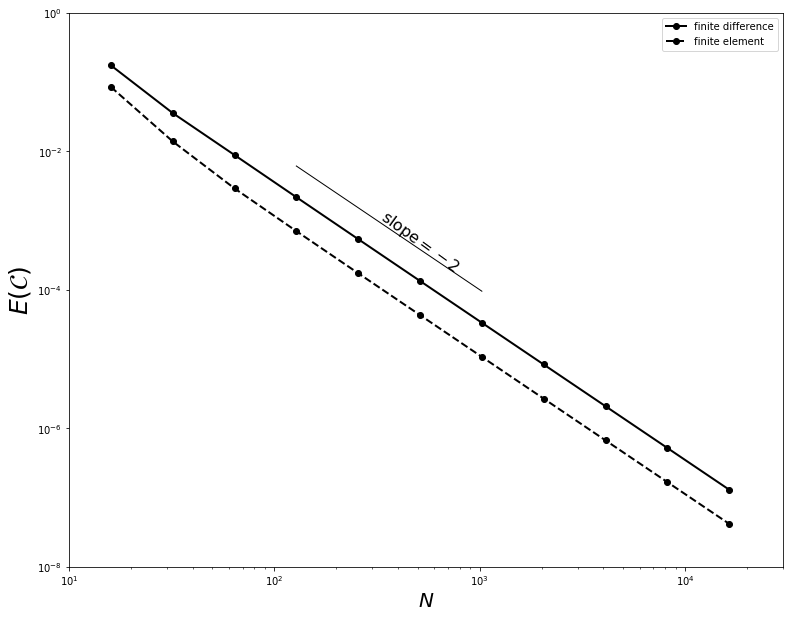

In [14]:
fig, ax = plt.subplots()
zoom = 2.0
fig.set_size_inches(6.4 * zoom, 5.1 * zoom)

# plotting
p1, = plt.loglog(par.ni, err_fd, '-ok', linewidth=2)
p2, = plt.loglog(par.ni, err_fe, '--ok', linewidth=2)
plt.loglog(par.ni[3:7], 100*np.power(par.ni[3:7], -2), '-k', linewidth=1)
plt.xlabel(r'$N$', fontsize=20)
plt.ylabel(r'$E(\mathcal{C})$', fontsize=25)
plt.text(par.ni[5], 190*np.power(par.ni[6], -2), r'slope$=-2$', 
         fontsize=16, rotation=-36, horizontalalignment='center')
plt.xlim(10.0, 3.e4)
plt.ylim(1.e-8, 1.0)
leg = plt.legend(handles=[p1, p2], labels=['finite difference', 'finite element'])
plt.show()

## A 2-D manufactured solution (instantaneous)

The manufactured solution, computed using equations \eqref{eq:num-manufac-solution}, for $m=2$, $\psi^*=\scalarpotential^*=1$, and $\phi^*=0.1$. All quantities are dimensionless. The pressure $\pres_\manufac$ is not shown. __(a)__ The shear potential $\psi_\manufac$ is shown in grayscale; vectors illustrate $\Curl\psi_\manufac\zhat$, the incompressible part of the flow. __(b)__ The compaction potential $\scalarpotential_\manufac$ is shown in grayscale; vectors illustrate $\Grad\scalarpotential_\manufac$, the compaction part of the flow. __(c)__ The porosity $\phi_\manufac$ is shown in grayscale; vectors illustrate the total solid flow field $\vel\sol_\manufac$.

Error $\error$ versus number of nodes $\sqrt{N}$ along one direction. Solutions are obtained by finite-difference discretisation of the Stokes/Darcy system \eqref{eq:num_mfcsol_gov}. The solid line marks the velocity error; the dashed line marks the pressure error. The analytical (manufactured) solution is shown in Figure \ref{fig:manufactured_solution}.